# Basic principle of Planetary Radar:
Transmit short pulses at a given frequency for distance/c time
 * pulse duration should be ... pretty short (have to sum up many pulses to deal with noise)
 * pulse interval should be longer than the delay dispersion
 * or use coded long pulse waveform (pseudo-random)
 * Receive the echos, compute the response for each cell in a doppler delay grid (doppler varies across the limbs, delay varies with distance)

# Relevant papers
 * [Radar Echoes From the Moon](https://web.archive.org/web/20081029000712/http://www.eagle.ca/~harry/ba/eme/index.htm) -- historical
 * [Planetary Radar - State-of-the-Art Review](https://www.mdpi.com/2072-4292/15/23/5605) -- 2023 overview
 * [Planetary Radar Astronomy](https://nap.nationalacademies.org/read/21729/chapter/8) -- 2015 overview
 * [Planetary Radar](https://echo.jpl.nasa.gov/asteroids/ostro_1998_encyc_ss.pdf) -- 1998 overview
 * [Planetary Delay-Doppler Radar and the Long-Code Method](https://echo.jpl.nasa.gov/asteroids/harmon.2002.long.code.pdf) -- long-code method (recommends intercode -- coherent code sequence) for underspread Moon
 * [Earth-Based Radar Observations of Venus -- PDS Archive Description](https://pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/document/venus_radar.pdf) -- Arecibo Venus data description

In [1]:
# Dependencies
#! pip install --quiet --upgrade astropy cupy-cuda12x ipympl jplephem matplotlib numpy scipy sigmf tqdm

In [2]:
import numpy as np
from matplotlib import pyplot as pl

from astropy import units as au
from astropy import constants as ak
from astropy import coordinates as ac
from astropy import time as at

import cupy

import scipy
import sigmf
from tqdm import tqdm

In [3]:
# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")
#ac.solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'de440s'>

In [93]:
# Constants
DWINGELOO_LAT = 52.81214958283062 * au.degree
DWINGELOO_LON = 6.396319071523311 * au.degree
DWINGELOO_HEIGHT = 70.26 * au.m

STOCKERT_LAT = 50.56944039751571 * au.degree
STOCKERT_LON = 6.721943350231514 * au.degree
STOCKERT_HEIGHT = 434.0 * au.m

#MOON_RADIUS = 1_738_100.0 * au.m   # Equatorial radius
MOON_RADIUS = 1_737_400.0 * au.m   # Volumetric mean radius
#MOON_RADIUS = 17_000_000.0 * au.m   # HACK HACK HACK --> range needed to explain a ~0.03 Hz doppler error.

TX_START = (1.000011 - 11.926e-6) * au.s  # From Thomas' notebook "Stockert, correct for H-maser offset Dwingeloo (1 MHz)"

DATA_ROOT = 'data'

In [5]:
rx_chan0_filename = f"{DATA_ROOT}/sdr-eme/rx-2025-03-11/stockert_eme_2025_03_11_19_36_21_1297.500MHz_1.00Msps_ci16_le.chan0.sigmf-meta"
rx_chan1_filename = f"{DATA_ROOT}/sdr-eme/rx-2025-03-11/stockert_eme_2025_03_11_19_36_21_1297.500MHz_1.00Msps_ci16_le.chan1.sigmf-meta"
#tx_file = f"{DATA_ROOT}/sdr-eme/rx-2025-03-11/stockert_eme_2025_03_11_19_36_21_1297.500MHz_1.00Msps_ci16_le.chan0.sigmf-meta"

In [6]:
# Load the rx data
if 1: # Just use one polarity
    rx_sigmf_file = sigmf.sigmffile.fromfile(rx_chan0_filename)
    #rx_sigmf_file = sigmf.sigmffile.fromfile(rx_chan1_filename)
    rx_samples = rx_sigmf_file.read_samples().astype("complex64")
    
    ## Normalize the average power.
    #rx_samples /= np.mean(np.abs(rx_samples))

if 0: # Combine both polarities:
    # Chan 0 is RHCP
    rx_sigmf_file = rx_chan0_sigmf_file = sigmf.sigmffile.fromfile(rx_chan0_filename)
    # Chan 0 is LHCP
    rx_chan1_sigmf_file = sigmf.sigmffile.fromfile(rx_chan1_filename)
    rx_chan0_samples = rx_chan0_sigmf_file.read_samples().astype("complex64")
    rx_chan1_samples = rx_chan1_sigmf_file.read_samples().astype("complex64")

    ## Normalize the average channel power.
    #rx_chan0_samples /= np.mean(np.abs(rx_chan0_samples))
    #rx_chan1_samples /= np.mean(np.abs(rx_chan1_samples))
    
    # From Thomas' code: Combine RHCP at 80 degrees (cross-pol), LHCP at 260 (co-pol)
    rx_samples = rx_chan0_samples + np.exp(1j * 260 * np.pi / 180) * rx_chan1_samples

rx_info = rx_sigmf_file.get_global_info()
sample_rate = rx_info['core:sample_rate'] / au.s
tx_filename = rx_info['core:description']
print(f"{tx_filename=}")

captures = rx_sigmf_file.get_captures()
frequency = captures[0]['core:frequency'] * au.Hz
rx_start_astrotime = at.Time(captures[0]['core:datetime'])

tx_filename='zadoff-chu-50000-1500007-503-0-30-1.sigmf-meta'


In [7]:
print(captures[0]['core:datetime'])
print(rx_start_astrotime)


2025-03-11T19:36:21.000039
2025-03-11T19:36:21.000


In [16]:
if 1:  # Debug: Basic file info
    display(rx_sigmf_file.get_global_info())
    display(rx_sigmf_file.get_captures())
    
if 0: # Debug: Not a very informative plot!
    pl.figure(figsize=(20, 5))
    pl.plot(rx_samples.real, ',')

{'core:version': '1.2.5',
 'core:recorder': 'vrt_to_sigmf',
 'core:sample_rate': 1000000,
 'core:datatype': 'ci16_le',
 'core:author': 'Thomas Telkamp/Cees Bassa/Wolfgang Herrmann',
 'core:description': 'zadoff-chu-50000-1500007-503-0-30-1.sigmf-meta',
 'dt:datetime': '2025-03-11T19:36:20.000000',
 'dt:pointing:active_tracker': 'idle',
 'dt:pointing:tracking_enabled': 'false',
 'dt:pointing:refraction': 'false',
 'dt:pointing:dt_model': 'false',
 'dt:pointing:refraction_j2000': 'false',
 'dt:pointing:dt_model_j2000': 'false',
 'dt:pointing:current:az_deg': 126.127,
 'dt:pointing:current:el_deg': 44.447,
 'dt:pointing:error:az_deg': 0.0,
 'dt:pointing:error:el_deg': 0.0,
 'dt:pointing:offset:az_deg': 0.0,
 'dt:pointing:offset:el_deg': 0.0,
 'dt:pointing:az_speed_deg_s': 0.0,
 'dt:pointing:el_speed_deg_s': 0.0,
 'dt:pointing:setpoint:ra_h': 9.798,
 'dt:pointing:setpoint:dec_deg': 15.977,
 'dt:pointing:current:ra_h': 9.801,
 'dt:pointing:current:dec_deg': 15.979,
 'dt:pointing:model:a0': 

[{'core:sample_start': 0,
  'core:frequency': 1297500000,
  'core:datetime': '2025-03-11T19:36:21.000039'}]

In [9]:
if 0: # Debug: rx spectrogram
    %matplotlib widget
    pl.figure()
    Sxx_rx, f_rx, t_rx, image_rx = pl.specgram(rx_samples, Fs=sample_rate, NFFT=2**12, clim=[-110, -80])
    pl.gca().set_xlabel("Time (s)")
    pl.gca().set_ylabel("Frequency from center (Hz)")
    pl.gca().axvline(transmission_start, color="white", linestyle="--")
    pl.gca().axvline(transmission_start + expected_delay, color="white", linestyle="--")

In [10]:
# Load the tx waveform data
tx_sigmf_filename = f"{DATA_ROOT}/sdr-eme/tx/{tx_filename}"
tx_sigmf_file = sigmf.sigmffile.fromfile(tx_sigmf_filename)
tx_samples = tx_sigmf_file.read_samples().astype("complex64")

tx_info = tx_sigmf_file.get_global_info()
display(tx_info)

{'core:author': 'Thomas Telkamp',
 'core:datatype': 'ci16_le',
 'core:description': 'EME signal',
 'core:sample_rate': 1000000.0,
 'core:sha512': '4323862c4eaede0d9ae029c928ff9e7dd162a8755ac11b1b741f148f451864defd00158d548614498f17c1fbb10d0a2fbe7ff7de5635351162937e55c8731d30',
 'core:version': '1.2.5',
 'vrt:tx_gain': 10,
 'core:num_channels': 1}

In [11]:
if 0: # Debug: tx spectrogram
    nfft = nperseg = 2**8
    Sxx_tx, f_tx, t_tx, image_tx = pl.specgram(tx_samples, Fs=sample_rate, NFFT=nfft)

In [12]:
if 0: # Investigate the up-doppler/down-doppler asymmetry.
    v_base = 300 * au.m / au.s
    dv_limb = 3 * au.m / au.s
    doppler_base = frequency * (v_base) / ak.c
    doppler_inbound = frequency * (v_base - dv_limb) / ak.c
    doppler_outbound = frequency * (v_base + dv_limb) / ak.c
    print(doppler_base)
    print(doppler_inbound)
    print(doppler_outbound)
    print(doppler_base - doppler_inbound)
    print(doppler_outbound - doppler_base)
    print(doppler_base - doppler_inbound - doppler_outbound + doppler_base)
    # ... it ain't much!

In [74]:
# Note: we calculate the doppler at the start and end of rx, not tx, because we will use it to
# correct rx_samples.
# There are a lot of different ways to compute this: astropy, jplHorizons, poliastro, spicey.

## SIMPLE
#def moonDopplerAndDelay_astropy(rx_time, tx_location, rx_location):
#    approx_moon_gcrs = ac.get_body("moon", rx_time, location=tx_location)
#    approx_light_travel_time = (approx_moon_gcrs.distance - MOON_RADIUS) / ak.c
#    
#    # Transmit "up" from Dwingeloo to the moon.
#    # NOTE: get_body returns the apparent position of the object at the observer's time and location,
#    # so for "up", we really want the earth-observed-from-moon direction, but we can only get moon-observed-from-earth.
#    # Since astropy get_body doesn't give radial velocity directly, we simply take the derivative of the range!
#    dt = 0.1 * au.s
#    up_moon_gcrs_1 = ac.get_body("moon", rx_time - approx_light_travel_time - dt, location=tx_location)
#    up_moon_gcrs_2 = ac.get_body("moon", rx_time - approx_light_travel_time + dt, location=tx_location)
#    up_radial_velocity = ((up_moon_gcrs_2.distance - up_moon_gcrs_1.distance) / (2 * dt)).to(au.m / au.s)
#    
#    # Receive "down" from the moon to Stockert. Note: we actually get the "up" path, just with a slight delay.
#    down_moon_gcrs_1 = ac.get_body("moon", rx_time - dt, location=rx_location)
#    down_moon_gcrs_2 = ac.get_body("moon", rx_time + dt, location=rx_location)
#    down_radial_velocity = ((down_moon_gcrs_2.distance - down_moon_gcrs_1.distance) / (2 * dt)).to(au.m / au.s)
#    
#    delay = (up_moon_gcrs_1.distance + down_moon_gcrs_2.distance - 2 * MOON_RADIUS) / ak.c
#    doppler = frequency * (up_radial_velocity + down_radial_velocity) / ak.c
#    return doppler, delay.to(au.s)

In [94]:
# More complex, try to consider all the light travel times.
def moonDopplerAndDelay_astropy(rx_time, tx_location, rx_location):
    # We'll use the doppler to correct the rx_samples, so all calculations are relative to rx_time.
    # We need three ICRS positions and velocities:
    #  - rx_location at rx_time
    #  - moon at the time of a bounce that is received at rx_time
    #  - tx_location at the time of a transmission that bounces and then is received at rx_time
    rx_gcrs = rx_location.get_gcrs(rx_time)
    rx_icrs = rx_gcrs.transform_to(ac.ICRS())

    # Iterate to converge on the "bounce_time" of the apparent moon_surface, given the rx_location and rx_time.
    delta_light_travel_time = 20.0 * au.s
    bounce_time = rx_time
    approx_down_light_travel_time = 0.0 * au.s
    while np.any(np.fabs(delta_light_travel_time) > 1.0e-8 * au.s):
        moon_pos, moon_vel = ac.get_body_barycentric_posvel("moon", bounce_time)
        bc_down_dpos = moon_pos - rx_icrs.cartesian.without_differentials()
        bc_down_direction = bc_down_dpos / bc_down_dpos.norm()
        moon_surface_pos = moon_pos - MOON_RADIUS * bc_down_direction;
        distance = (moon_surface_pos - rx_icrs.cartesian.without_differentials()).norm()
        delta_light_travel_time = approx_down_light_travel_time - distance / ak.c
        approx_down_light_travel_time = distance / ak.c
        bounce_time = rx_time - approx_down_light_travel_time
    # Calculate moon_pos/vel once more with the best bounce_time    
    moon_pos, moon_vel = ac.get_body_barycentric_posvel("moon", bounce_time)
    bc_down_dpos = moon_pos - rx_icrs.cartesian.without_differentials()
    bc_down_direction = bc_down_dpos / bc_down_dpos.norm()
    # Find the moon surface sub-radar point (approximate because we're not using the lunar geoid)
    moon_surface_pos = moon_pos - MOON_RADIUS * bc_down_direction;
    down_dpos = moon_surface_pos - rx_icrs.cartesian.without_differentials()
    down_range = down_dpos.norm()
    down_dvel = (moon_vel - rx_icrs.velocity)
    down_direction = down_dpos / down_range
    down_range_rate = np.dot(down_dvel.xyz.to(au.m / au.s).value, down_direction.xyz) * au.m / au.s

    # Iterate to converge on the "emitted_time" of the apparent tx_location, given the moon_surface_loc and bounce_time.
    delta_light_travel_time = 20.0 * au.s
    emitted_time = rx_time - approx_down_light_travel_time
    approx_up_light_travel_time = 0.0 * au.s
    while np.any(np.fabs(delta_light_travel_time) > 1.0e-8 * au.s):
        tx_gcrs = tx_location.get_gcrs(emitted_time)
        tx_icrs = tx_gcrs.transform_to(ac.ICRS())
        distance = (tx_icrs.cartesian.without_differentials() - moon_surface_pos).norm()
        delta_light_travel_time = approx_up_light_travel_time - distance / ak.c
        approx_up_light_travel_time = distance / ak.c
        emitted_time = rx_time - approx_down_light_travel_time - approx_up_light_travel_time
    # Calculate tx_icrs once more with the best emitted_time
    tx_gcrs = tx_location.get_gcrs(emitted_time)
    tx_icrs = tx_gcrs.transform_to(ac.ICRS())
    up_dpos = tx_icrs.cartesian.without_differentials() - moon_surface_pos
    up_range = up_dpos.norm()
    up_dvel = (tx_icrs.velocity - moon_vel)
    up_direction = up_dpos / up_range
    up_range_rate = np.dot(up_dvel.xyz.to(au.m / au.s).value, up_direction.xyz) * au.m / au.s

    doppler = frequency * (up_range_rate + down_range_rate) / ak.c
    delay = (up_range + down_range) / ak.c

    return doppler, delay

In [ ]:
import spicepy
spiceypy.furnsh(f"~/.astropy//naif0012.tls")

def radar_surface_dlt(target, surf_vec, surf_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    target_radius = sp.bodvrd(target, 'RADII', 3)[1][0]
    surf_vec = np.array(surf_vec)
    surf_vec = target_radius * sp.unorm(surf_vec)[0]
    ez_r, lt_r = sp.spkcpt(surf_vec, target, surf_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', surf_vec, target, surf_frame)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

def moonDopplerAndDelay_astropy(rx_time, tx_location, rx_location):
    pass

In [95]:

tx_location = ac.EarthLocation(lat=DWINGELOO_LAT, lon=DWINGELOO_LON, height=DWINGELOO_HEIGHT, ellipsoid="WGS84")
rx_location = ac.EarthLocation(lat=STOCKERT_LAT, lon=STOCKERT_LON, height=STOCKERT_HEIGHT, ellipsoid="WGS84")

#rx_start_astrotime_HACK= rx_start_astrotime + 0.20 * au.s  # HACK HACK HACK: time error needed to explain a ~0.03 Hz doppler error.
#doppler_start, delay_start = moonDopplerAndDelay_astropy(rx_start_astrotime_HACK, tx_location, rx_location)
doppler_start, delay_start = moonDopplerAndDelay_astropy(rx_start_astrotime, tx_location, rx_location)
print(f"{doppler_start=} {delay_start=}")

#rx_end_astrotime_HACK = rx_start_astrotime_HACK + rx_duration
#doppler_end, delay_end = moonDopplerAndDelay_astropy(rx_end_astrotime_HACK, tx_location, rx_location)
rx_duration = len(rx_samples) / sample_rate
rx_end_astrotime = rx_start_astrotime + rx_duration
doppler_end, delay_end = moonDopplerAndDelay_astropy(rx_end_astrotime, tx_location, rx_location)
print(f"{doppler_end=} {delay_end=}")

# Simple linear doppler_rate model, from start to end
doppler_rate = (doppler_end - doppler_start) / rx_duration
print(f"{doppler_rate=}")

doppler_start=<Quantity -1046.60174679 Hz> delay_start=<Quantity 2.49061564 s>
doppler_end=<Quantity -1041.87888019 Hz> delay_end=<Quantity 2.49058667 s>
doppler_rate=<Quantity 0.13119074 Hz / s>


In [55]:
if 1:  # HACK: manually override doppler delay parameters
    print("HACK HACK HACK")
    
    #  These are from Thomas' notebook.
    # ... but they're not perfect (see final image symmetry)
    #doppler_start = -1046.669 * au.Hz
    #doppler_rate = 0.13120475496564593 * au.Hz / au.s 
    #delay_start = 2.592436 * au.s 

    # MANUAL BEST FIT (first doppler_start using delay-doppler image left-right symmetry), then delay_start using the correlation spike.
    doppler_start = -1046.605 * au.Hz
    doppler_rate = 0.13120475496564593 * au.Hz / au.s 
    delay_start = 2.59245 * au.s
    print(f"{doppler_start=}")
    print(f"{delay_start=}")
    print(f"{doppler_rate=}")

HACK HACK HACK
doppler_start=<Quantity -1046.605 Hz>
delay_start=<Quantity 2.59245 s>
doppler_rate=<Quantity 0.13120475 Hz / s>


In [52]:
# Compensate for time-varying doppler (sum of dopplers from transmitter -> moon, and moon -> receiver)
t_s = np.arange(len(rx_samples)) / sample_rate
phi_Hz = (-doppler_start * t_s) + (-doppler_rate * t_s**2) / 2  # Instantaneous phase.
rx_samples_compensated = rx_samples * np.exp(-1j * 2 * np.pi * phi_Hz.value).T

In [53]:
if 0: # Debug: compensated rx spectrogram
    %matplotlib widget
    pl.figure()
    nfft = nperseg = 2**8
    Sxx_rx, f_rx, t_rx, image_rx = pl.specgram(rx_samples_compensated, Fs=sample_rate, NFFT=nfft, clim=[-110, -80])
    pl.grid()

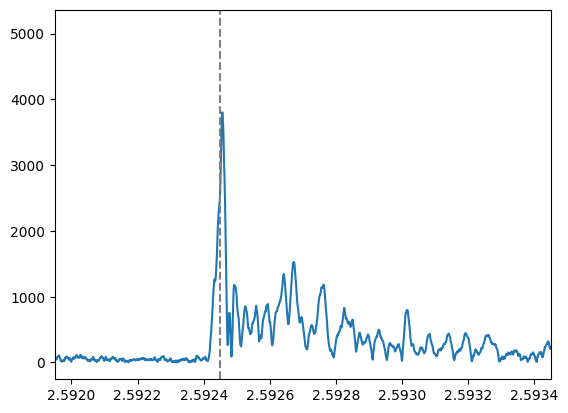

In [56]:
if 1:  # Check expected delay and doppler.
    #%matplotlib widget
    cor = scipy.signal.correlate(rx_samples_compensated, tx_samples, mode='full')
    cor_lags = scipy.signal.correlation_lags(len(rx_samples_compensated), len(tx_samples), mode="full")
    pl.figure()
    pl.plot((cor_lags / sample_rate) - TX_START, np.abs(cor), label="signal")
    pl.gca().set_xlim([delay_start.value - 0.0005, delay_start.value + 0.001])
    pl.gca().axvline(delay_start.value, linestyle="--", color="grey", label="expected based on Moon distance",)

In [19]:
## Reference CPU implementation. About 3 s/it. (seconds per iteration!)
#def correlateSignal(tx_samples, rx_samples):
#    # HACK: Hard-code search parameters for now...
#    echo_window = [5410000, 12300000]
#    delay_start = 2_805_000
#    delay_end = 2_840_000
#    f_shifts = range(-250, 251, 1)
#    #f_shifts = range(-650, -51, 1)
#    A = np.zeros((len(f_shifts), delay_end - delay_start))
#
#    for i in tqdm(range(len(f_shifts))):
#        tx_samples_shifted = scipy.signal.resample(tx_samples, 5_000_000 + f_shifts[i])
#        c_shifted = scipy.signal.correlate(rx_samples[echo_window[0]:echo_window[1]], tx_samples_shifted, mode='same')
#        A[i] = np.abs(c_shifted[delay_start:delay_end])
#
#    return A

In [20]:
## Parallelized CPU implementation. About 1.5 it/s.
#import joblib
#
#def correlateSignalParallel(tx_samples, rx_samples):
#    # HACK: Hard-code parameters for now...
#    echo_window = [5410000, 12300000]
#    delay_start = 2_805_000
#    delay_end = 2_840_000
#    f_shifts = range(-250, 251, 1)
#    #f_shifts = range(-650, -51, 1)
#    
#    # Perform correlation for a single shift
#    def processShift(f_shift):
#        #tx_samples_shifted = scipy.signal.resample(tx_samples, len(tx_samples) + f_shift)
#        tx_samples_shifted = scipy.signal.resample(tx_samples, 5_000_000 + f_shift)
#        c_shifted = scipy.signal.correlate(rx_samples[echo_window[0]:echo_window[1]], tx_samples_shifted, mode='same')
#        correlation_slice = c_shifted[delay_start:delay_end]
#        return np.abs(correlation_slice)
#
#    # I find that using ~12 jobs on a 12 core Ryzen (which has 24 logical cpus) yields the best throughput.
#    results = joblib.Parallel(n_jobs=-4)(joblib.delayed(processShift)(f_shift) for f_shift in tqdm(f_shifts, desc="Correlating Shifts"))
#    A = np.vstack(results)
#    return A

In [21]:
# CUDA implementation: about 50 it/s on an nvidia rtx 3080
def correlateSignalCUDA(tx_samples, rx_samples, i_start, i_end, f_shifts):
    # Do everything in GPU memory, if it fits!
    tx_samples = cupy.asarray(tx_samples, dtype=cupy.complex64)
    rx_samples = cupy.asarray(rx_samples, dtype=cupy.complex64)
    A = cupy.asarray(np.zeros((len(f_shifts), i_end - i_start)))
    # Cache computations/allocations outside the for loop.
    fft_rx_samples = cupy.fft.fft(rx_samples)
    tx_samples_shifted = cupy.zeros_like(rx_samples)
    tx_range = cupy.arange(len(tx_samples))
    for i in tqdm(range(len(f_shifts))):
        tx_samples_shifted[:len(tx_samples)] = tx_samples * cupy.exp(-1j * 2 * cupy.pi * (f_shifts[i] / sample_rate.value) * tx_range)
        cor_shifted = cupy.fft.ifft(fft_rx_samples * cupy.conj(cupy.fft.fft(tx_samples_shifted)))
        A[i] = cupy.abs(cor_shifted[i_start:i_end])
    # Single copy back to CPU at the end.
    return cupy.asnumpy(A)

In [22]:
moon_delay_depth = MOON_RADIUS / ak.c * 2  # round-trip delay depth
#print(f"{moon_depth.value=}")
t_start = TX_START + delay_start - 0.001 * au.s
t_end = TX_START + delay_start + moon_delay_depth + 0.002 * au.s

cor_lags = scipy.signal.correlation_lags(len(rx_samples_compensated), len(tx_samples), mode="valid")
i_start = np.argwhere(cor_lags > (t_start * sample_rate))[0][0]
i_end = np.argwhere(cor_lags > (t_end * sample_rate))[0][0]
print(t_start, t_end)
print(i_start, i_end)
print(i_end - i_start)

3.5914311870575424 s 3.60602654213482 s
3591432 3606027
14595


In [23]:
# NOTE: hard-code doppler frequency shifts
f_shifts = np.arange(-15, 15, 0.02)

# A = correlateSignal(tx_samples, rx_samples_compensated) # ~3 s per frequency shift iteration
# A = correlateSignalParallel(tx_samples, rx_samples_compensated)  # ~3x faster than cpu parallel version
A = correlateSignalCUDA(tx_samples, rx_samples_compensated, i_start, i_end, f_shifts) # >100x faster than reference

100%|█████████████████████████████████████████████████████████████████| 1500/1500 [02:08<00:00, 11.70it/s]


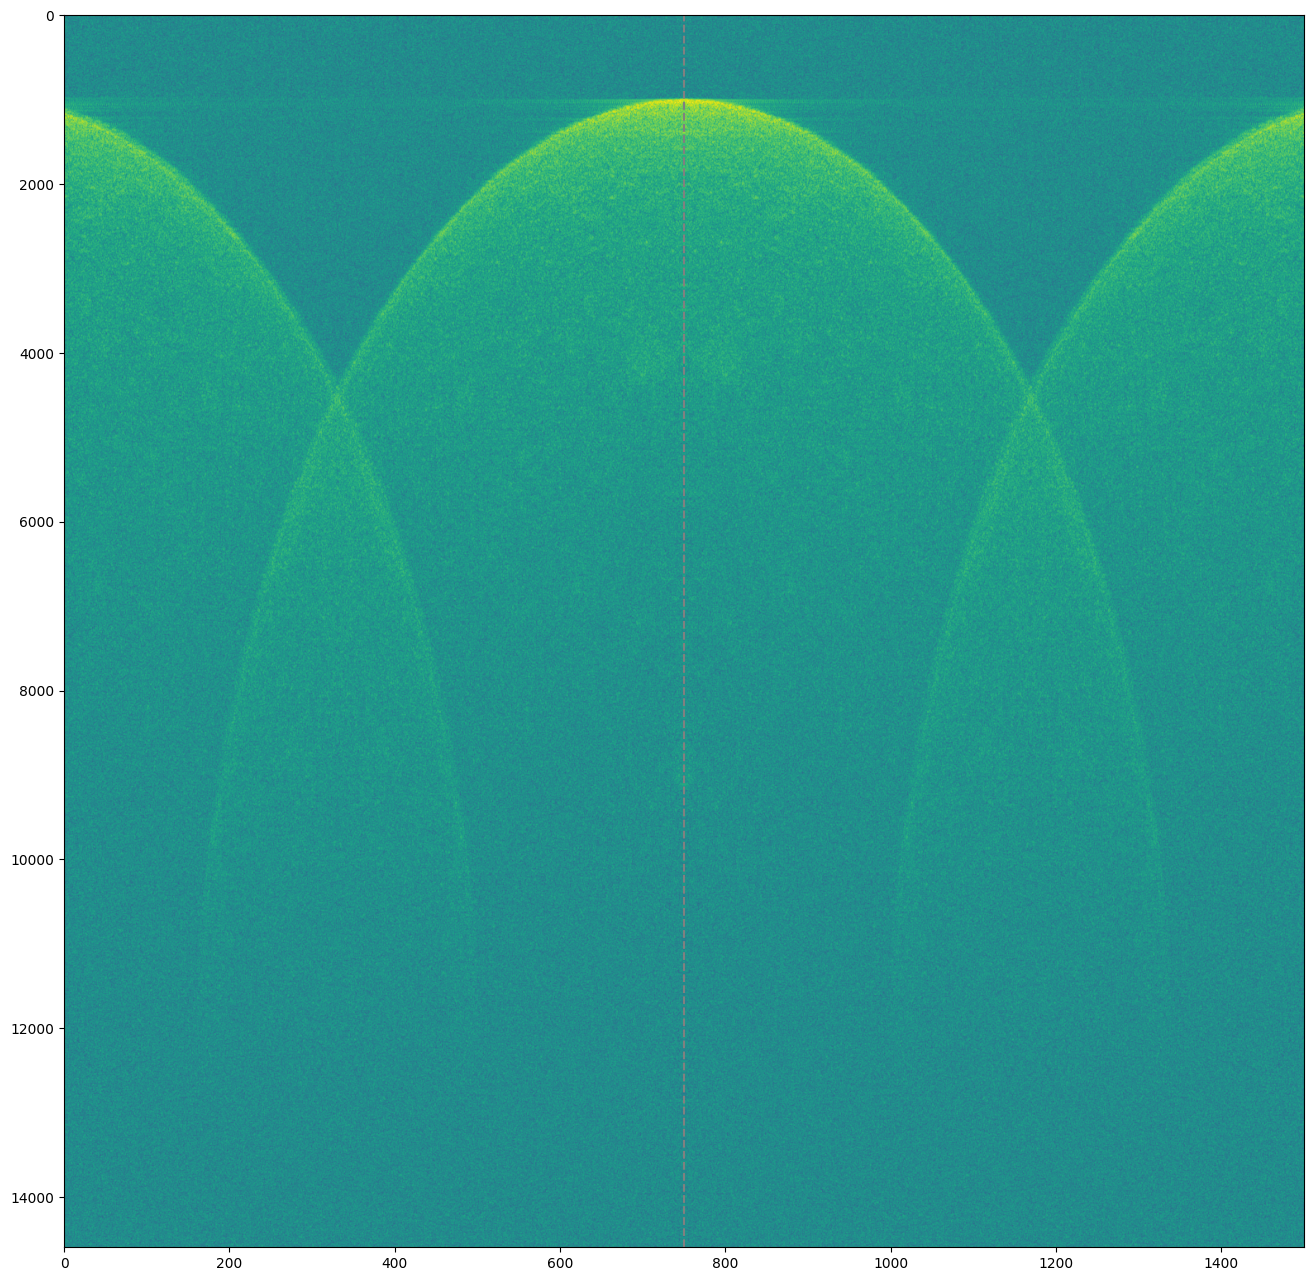

In [24]:
if 1: # Debug the central doppler frequency by flipping horizontally and summing.
    #%matplotlib widget
    pl.figure(figsize=(16,16))
    log_A = np.log(A)
    pl.imshow(log_A.T + log_A.T[:, ::-1], aspect='auto')  
    pl.gca().axvline(log_A.shape[0] / 2.0, linestyle="--",color="grey")

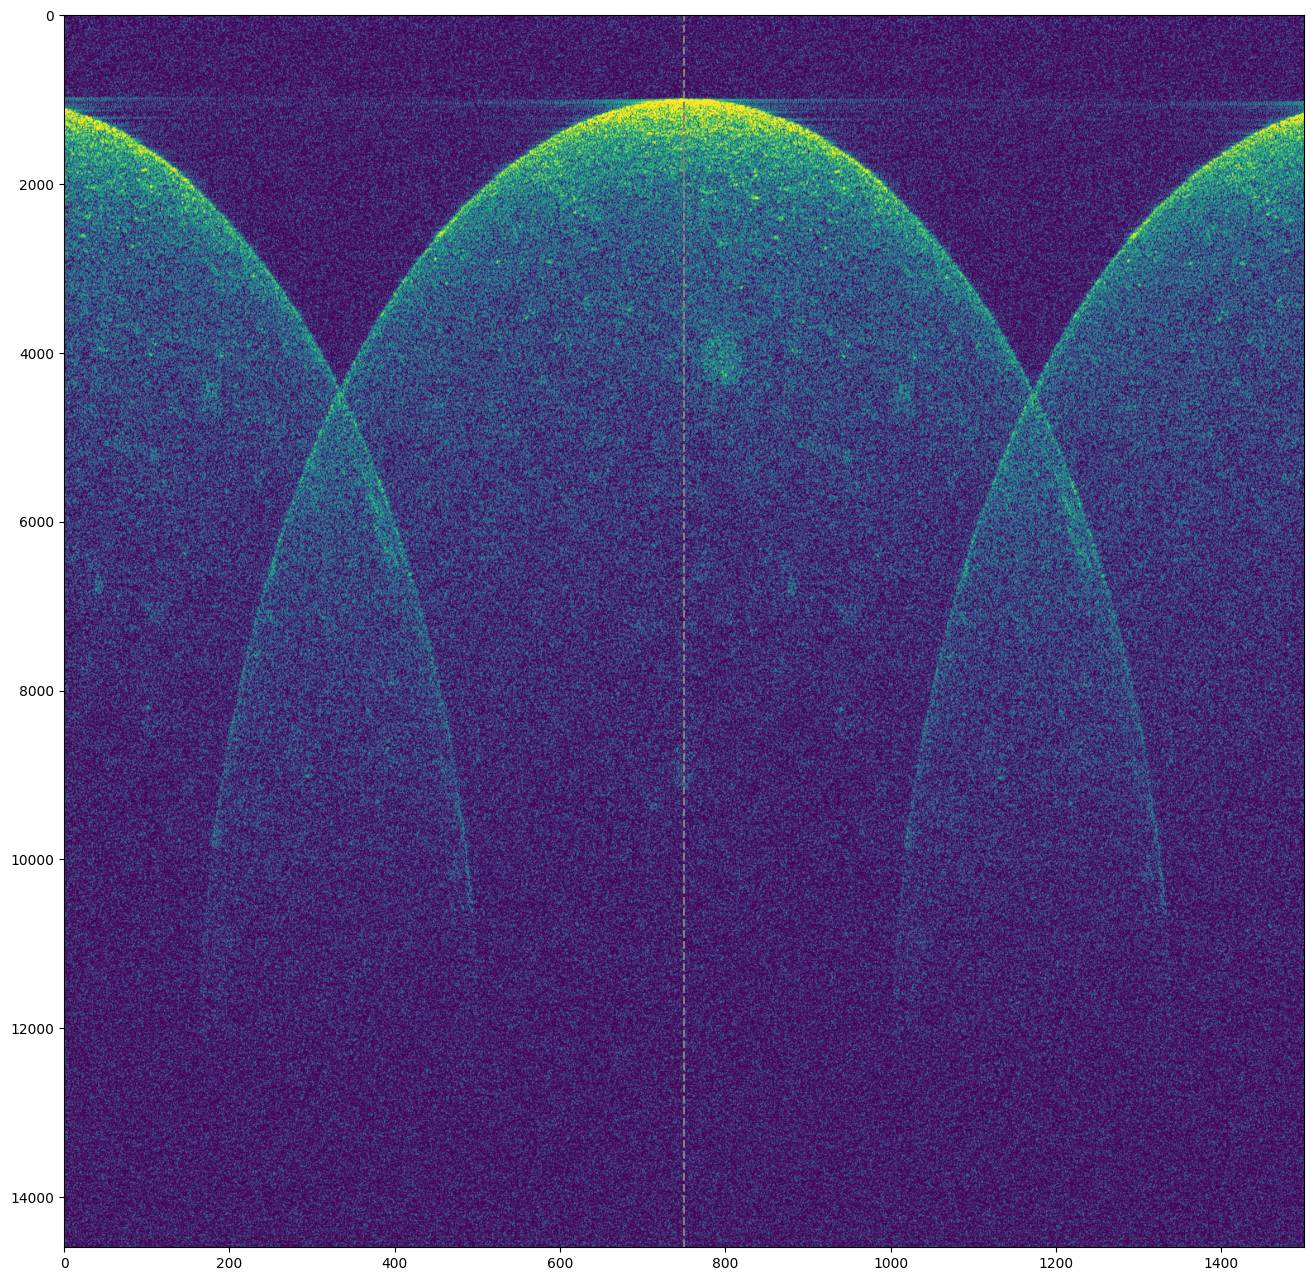

In [25]:
pl.figure(figsize=(16,16))
log_A = np.log(A)
pl.imshow(log_A.T, aspect='auto', vmax=log_A.max() * 0.8, vmin=log_A.max() * 0.4)
pl.gca().axvline(log_A.shape[0] / 2.0, linestyle="--",color="grey")